In [1]:
import os, tempfile

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
#plt.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Amount  Class  
0 -0.189115  0.133558 -0.021053  149.62      0  
1  0.125895 -0.008983  0.014724    2.69      0  
2 -0.139097 -0.055353 -0.059752  378.66      0  
3 -0.221929  0.062723  0.061458  123.50      0  
4  0.502292  0.219422  0.215153   69.99      0  

[5 rows x 31 columns]

In [5]:
raw_df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
raw_df.dtypes

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print(f"Examples:\n"
      f"    Total: {total}\n"
      f"    Positive: {pos} ({pos/total:.2%} of total)")

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)


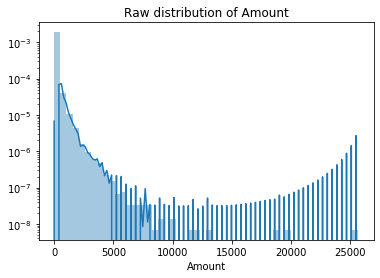

In [8]:
sns.distplot(raw_df['Amount'])
plt.yscale('log')
plt.title('Raw distribution of Amount')
plt.show()

In [9]:
(raw_df['Amount'] == 0).sum()

1825

In [10]:
(raw_df['Amount'][raw_df['Amount'] != 0]).min()

0.01

In [11]:
cleaned_df = raw_df.copy()
cleaned_df.pop('Time')
eps = 1e-6
cleaned_df['Log Amount'] = np.log(cleaned_df['Amount']+eps)
cleaned_df['Log1p Amount'] = np.log1p(cleaned_df['Amount'])

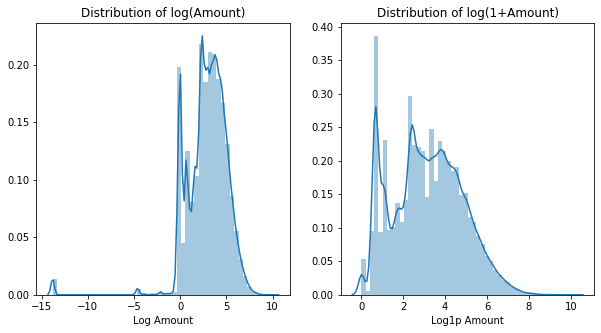

In [12]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(cleaned_df['Log Amount'])
plt.title('Distribution of log(Amount)')
plt.subplot(1,2,2)
sns.distplot(cleaned_df['Log1p Amount'])
plt.title('Distribution of log(1+Amount)')
plt.show()

* Deviate from the original example and try log1p

In [13]:
%%capture
cleaned_df.pop('Amount')
cleaned_df.pop('Log Amount')

In [14]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = train_df.pop('Class').values
bool_train_labels = (train_labels != 0)
val_labels = val_df.pop('Class').values
test_labels = test_df.pop('Class').values

train_features = train_df.values
val_features = val_df.values
test_features = test_df.values

In [15]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [16]:
#train_features = np.clip(train_features, -3, 3)
#val_features = np.clip(val_features, -3, 3)
#test_features = np.clip(test_features, -3, 3)

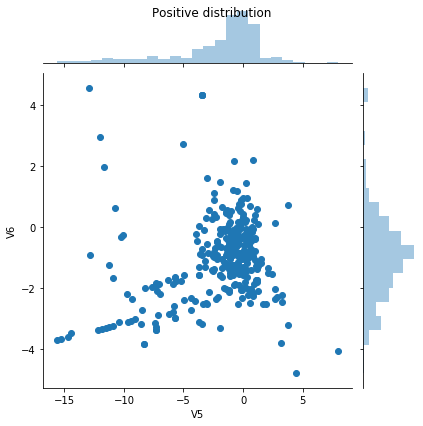

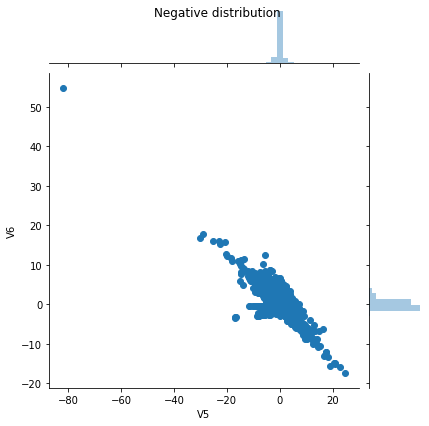

In [17]:
pos_df = pd.DataFrame(train_features[bool_train_labels],
                      columns = train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels],
                      columns = train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'])
plt.suptitle('Positive distribution')

sns.jointplot(neg_df['V5'], neg_df['V6'])
plt.suptitle('Negative distribution')

plt.show()

In [18]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = keras.initializers.Constant(output_bias)
    model = keras.Sequential([
        keras.layers.Dense(
            16, activation='relu',
            input_shape=(train_features.shape[1],)),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(
            16, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid',
                           bias_initializer=output_bias),
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3),
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model

In [19]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True)

In [20]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.predict(train_features[:10])

array([[0.37976617],
       [0.26247922],
       [0.3706051 ],
       [0.33683264],
       [0.26497123],
       [0.31929845],
       [0.29827422],
       [0.1394006 ],
       [0.28923044],
       [0.48964614]], dtype=float32)

In [22]:
results = model.evaluate(train_features, train_labels,
                         batch_size=BATCH_SIZE, verbose=0)
print(f"Loss: {results[0]:.4f}")

Loss: 0.3868


In [23]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

In [24]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00272545],
       [0.00236723],
       [0.00208691],
       [0.00151223],
       [0.00180024],
       [0.00363338],
       [0.00222182],
       [0.00208724],
       [0.00207945],
       [0.00133254]], dtype=float32)

In [25]:
results = model.evaluate(train_features, train_labels,
                         batch_size=BATCH_SIZE, verbose=0)
print(f"Loss: {results[0]:.4f}")

Loss: 0.0121


In [26]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [27]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE, epochs=20,
    validation_data=(val_features, val_labels))

Train on 182276 samples, validate on 45569 samples
Epoch 1/20
182276/182276 [==============================] - 2s 13us/sample - loss: 0.6049 - tp: 140.0000 - fp: 51650.0000 - tn: 130309.0000 - fn: 177.0000 - accuracy: 0.7157 - precision: 0.0027 - recall: 0.4416 - auc: 0.5157 - val_loss: 0.2192 - val_tp: 0.0000e+00 - val_fp: 3.0000 - val_tn: 45479.0000 - val_fn: 87.0000 - val_accuracy: 0.9980 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2483
Epoch 2/20
182276/182276 [==============================] - 0s 2us/sample - loss: 0.2062 - tp: 47.0000 - fp: 4480.0000 - tn: 177479.0000 - fn: 270.0000 - accuracy: 0.9739 - precision: 0.0104 - recall: 0.1483 - auc: 0.4036 - val_loss: 0.0537 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 45482.0000 - val_fn: 87.0000 - val_accuracy: 0.9981 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2220
Epoch 3/20
182276/182276 [==============================] - 0s 2us/sample - loss: 0.1007 - tp: 25.0000 - fp: 938.0000 

In [28]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE, epochs=20,
    validation_data=(val_features, val_labels))

Train on 182276 samples, validate on 45569 samples
Epoch 1/20
182276/182276 [==============================] - 2s 12us/sample - loss: 0.0158 - tp: 68.0000 - fp: 166.0000 - tn: 181793.0000 - fn: 249.0000 - accuracy: 0.9977 - precision: 0.2906 - recall: 0.2145 - auc: 0.7241 - val_loss: 0.0082 - val_tp: 19.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 68.0000 - val_accuracy: 0.9984 - val_precision: 0.7308 - val_recall: 0.2184 - val_auc: 0.8676
Epoch 2/20
182276/182276 [==============================] - 0s 2us/sample - loss: 0.0104 - tp: 75.0000 - fp: 34.0000 - tn: 181925.0000 - fn: 242.0000 - accuracy: 0.9985 - precision: 0.6881 - recall: 0.2366 - auc: 0.7709 - val_loss: 0.0072 - val_tp: 26.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 61.0000 - val_accuracy: 0.9985 - val_precision: 0.7879 - val_recall: 0.2989 - val_auc: 0.8791
Epoch 3/20
182276/182276 [==============================] - 0s 2us/sample - loss: 0.0088 - tp: 88.0000 - fp: 37.0000 - tn: 181922.0000 - fn: 229.0000

In [29]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'],
                 color=colors[n], label='Train '+label)
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=colors[n], label='Val '+label, ls='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

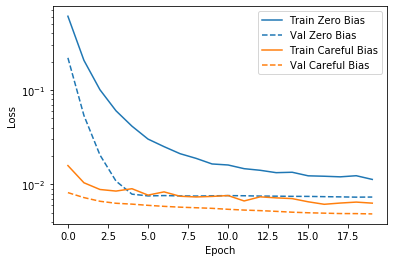

In [30]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [31]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 2s 13us/sample - loss: 0.0163 - tp: 64.0000 - fp: 189.0000 - tn: 181770.0000 - fn: 253.0000 - accuracy: 0.9976 - precision: 0.2530 - recall: 0.2019 - auc: 0.7262 - val_loss: 0.0083 - val_tp: 17.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 70.0000 - val_accuracy: 0.9983 - val_precision: 0.7083 - val_recall: 0.1954 - val_auc: 0.8675
Epoch 2/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.0106 - tp: 73.0000 - fp: 38.0000 - tn: 181921.0000 - fn: 244.0000 - accuracy: 0.9985 - precision: 0.6577 - recall: 0.2303 - auc: 0.7731 - val_loss: 0.0071 - val_tp: 27.0000 - val_fp: 7.0000 - val_tn: 45475.0000 - val_fn: 60.0000 - val_accuracy: 0.9985 - val_precision: 0.7941 - val_recall: 0.3103 - val_auc: 0.8791
Epoch 3/100
182276/182276 [==============================] - 1s 3us/sample - loss: 0.0096 - tp: 86.0000 - fp: 44.0000 - tn: 181915.0000 - fn: 231.0

In [32]:
def plot_metrics(history):
    metrics = ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(10,10))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], 
                 color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], ls='--', label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8, 1])
        else:
            plt.ylim([0, 1])
        plt.legend()
    plt.tight_layout()

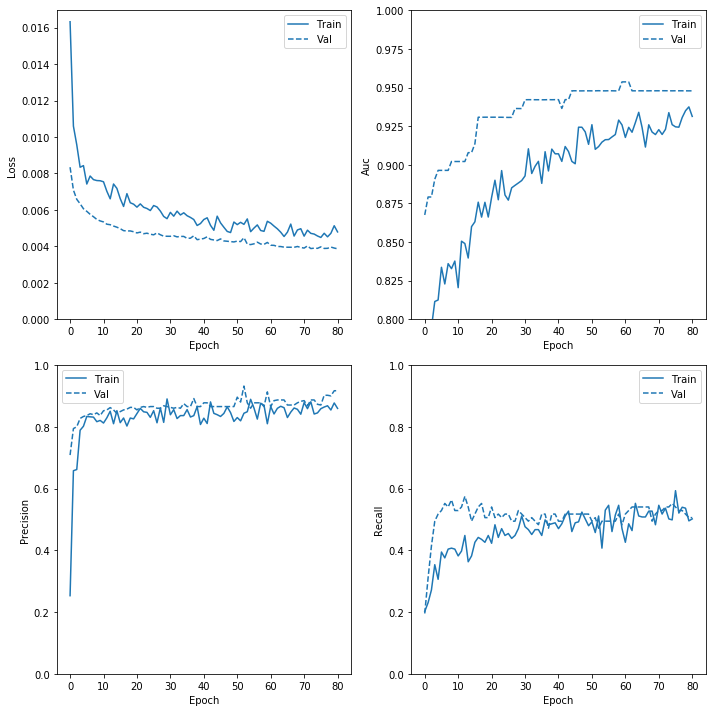

In [33]:
plot_metrics(baseline_history)

In [34]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [35]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.ylim([2,0])
    plt.title(f'Confusion matrix @{p:.2f}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

loss :  0.002495613362441851
tp :  52.0
fp :  3.0
tn :  56871.0
fn :  36.0
accuracy :  0.9993153
precision :  0.94545454
recall :  0.59090906
auc :  0.9600403


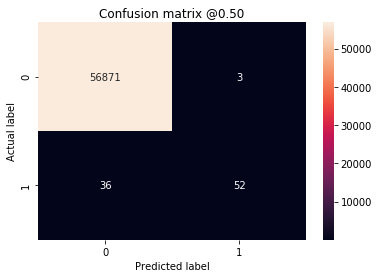

In [36]:
baseline_results = model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
    print(name, ': ', value)
plot_cm(test_labels, test_predictions_baseline)

In [37]:
def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(100*fp, 100*tp, label=name, lw=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.xlim(-0.5,100.5)
    plt.ylim(-0.5,100.5)
    plt.grid(True)
    plt.gca().set_aspect('equal')

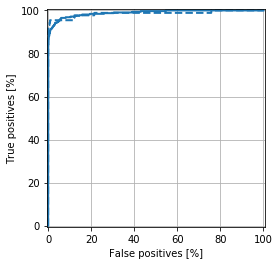

In [38]:
plot_roc('Train Baseline', train_labels, train_predictions_baseline, 
         color=colors[0])
plot_roc('Test Baseline', test_labels, test_predictions_baseline,
         color=colors[0], ls='--')

In [39]:
weight_for_0 = (1/neg)*total/2.0
weight_for_1 = (1/pos)*total/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Weight for class 0: {weight_for_0:.2f}")
print(f"Weight for class 1: {weight_for_1:.2f}")

Weight for class 0: 0.50
Weight for class 1: 289.44


In [40]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features, train_labels,
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    class_weight=class_weight)

Train on 182276 samples, validate on 45569 samples
Epoch 1/100
182276/182276 [==============================] - 2s 12us/sample - loss: 1.6280 - tp: 121.0000 - fp: 940.0000 - tn: 181019.0000 - fn: 196.0000 - accuracy: 0.9938 - precision: 0.1140 - recall: 0.3817 - auc: 0.7715 - val_loss: 0.7431 - val_tp: 56.0000 - val_fp: 69.0000 - val_tn: 45413.0000 - val_fn: 31.0000 - val_accuracy: 0.9978 - val_precision: 0.4480 - val_recall: 0.6437 - val_auc: 0.9353
Epoch 2/100
182276/182276 [==============================] - 0s 3us/sample - loss: 0.9981 - tp: 188.0000 - fp: 2221.0000 - tn: 179738.0000 - fn: 129.0000 - accuracy: 0.9871 - precision: 0.0780 - recall: 0.5931 - auc: 0.8238 - val_loss: 0.5004 - val_tp: 68.0000 - val_fp: 141.0000 - val_tn: 45341.0000 - val_fn: 19.0000 - val_accuracy: 0.9965 - val_precision: 0.3254 - val_recall: 0.7816 - val_auc: 0.9457
Epoch 3/100
182276/182276 [==============================] - 0s 2us/sample - loss: 0.8563 - tp: 204.0000 - fp: 4063.0000 - tn: 177896.0000 -

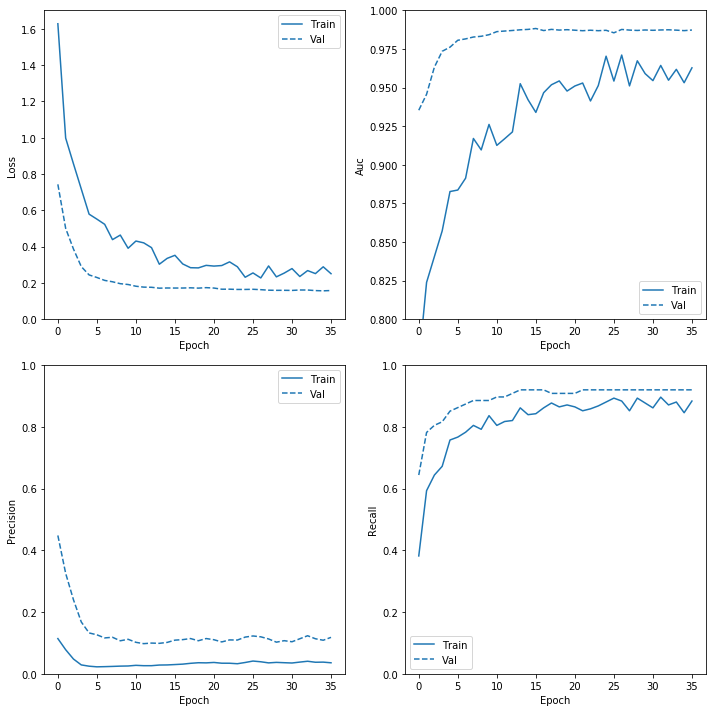

In [41]:
plot_metrics(weighted_history)

In [42]:
train_predictions_weighted = weighted_model.predict(
    train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(
    test_features, batch_size=BATCH_SIZE)

loss :  0.06771080122420821
tp :  80.0
fp :  776.0
tn :  56098.0
fn :  8.0
accuracy :  0.98623645
precision :  0.093457945
recall :  0.90909094
auc :  0.9724441


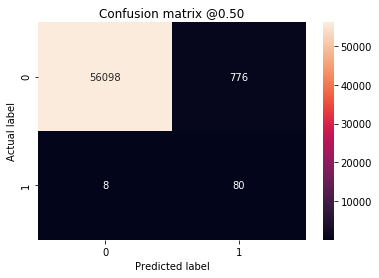

In [43]:
weighted_results = weighted_model.evaluate(
    test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions_weighted)

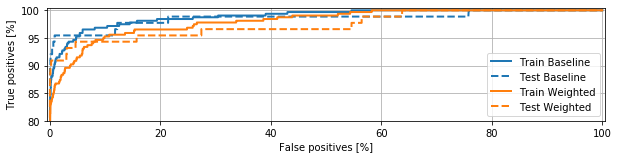

In [44]:
plt.figure(figsize=(10,10))

plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.ylim(80,100.5)

plt.legend(loc='lower right')

In [45]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [46]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))
res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(181959, 29)

In [47]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(363918, 29)

In [48]:
BUFFER_SIZE = 100000
def make_ds(features, labels):
    ds = tf.data.Dataset.from_tensor_slices((features, labels))
    ds = ds.shuffle(BUFFER_SIZE).repeat()
    return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [49]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5,0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [50]:
for features, label in resampled_ds.take(1):
    print(label.numpy().mean())

0.4990234375


In [51]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

In [52]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2)

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train for 278.0 steps, validate for 23 steps
Epoch 1/100
278/278 [==============================] - 10s 37ms/step - loss: 0.4171 - tp: 235263.0000 - fp: 67073.0000 - tn: 217166.0000 - fn: 49842.0000 - accuracy: 0.7946 - precision: 0.7782 - recall: 0.8252 - auc: 0.8914 - val_loss: 0.1600 - val_tp: 79.0000 - val_fp: 914.0000 - val_tn: 44568.0000 - val_fn: 8.0000 - val_accuracy: 0.9798 - val_precision: 0.0796 - val_recall: 0.9080 - val_auc: 0.9782
Epoch 2/100
278/278 [==============================] - 8s 28ms/step - loss: 0.2009 - tp: 251786.0000 - fp: 11511.0000 - tn: 273119.0000 - fn: 32928.0000 - accuracy: 0.9219 - precision: 0.9563 - recall: 0.8843 - auc: 0.9727 - val_loss: 0.0906 - val_tp: 79.0000 - val_fp: 928.0000 - val_tn: 44554.0000 - val_fn: 8.0000 - val_accuracy: 0.9795 - val_precision: 0.0785 - val_recall: 0.9080 - val_auc: 0.9804
Epoch 3/100
278/278 [==============================] - 8s 28ms/step - loss: 0.1548 - tp: 259860.0000 - fp: 9849.0000 - tn: 274194.0000 - fn: 25441.0

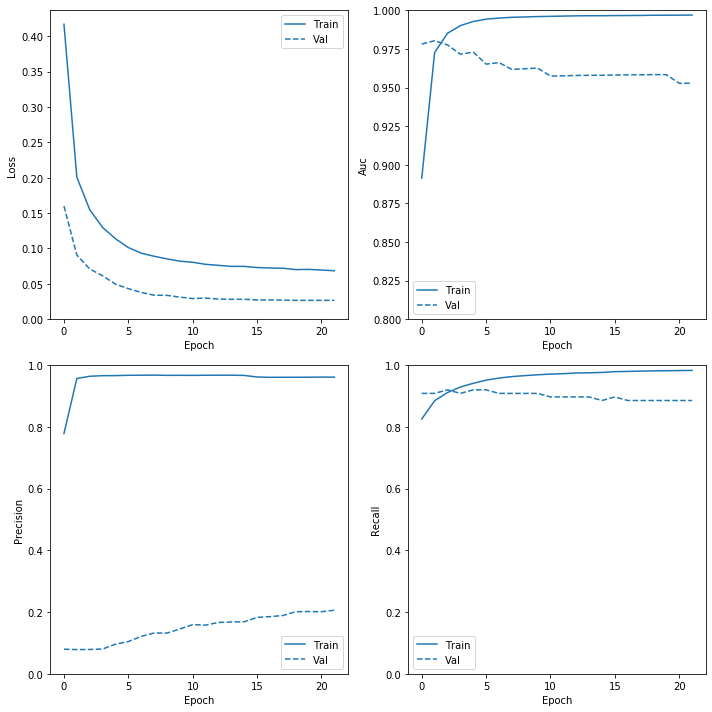

In [53]:
plot_metrics(resampled_history)

In [54]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

output_layer = resampled_model.layers[-1]
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=val_ds)

Train for 20 steps, validate for 23 steps
Epoch 1/1000
20/20 [==============================] - 3s 131ms/step - loss: 0.7809 - tp: 15441.0000 - fp: 12676.0000 - tn: 7722.0000 - fn: 5121.0000 - accuracy: 0.5655 - precision: 0.5492 - recall: 0.7509 - auc: 0.7106 - val_loss: 0.8064 - val_tp: 84.0000 - val_fp: 31336.0000 - val_tn: 14146.0000 - val_fn: 3.0000 - val_accuracy: 0.3123 - val_precision: 0.0027 - val_recall: 0.9655 - val_auc: 0.9022
Epoch 2/1000
20/20 [==============================] - 1s 30ms/step - loss: 0.6306 - tp: 16435.0000 - fp: 11235.0000 - tn: 9172.0000 - fn: 4118.0000 - accuracy: 0.6252 - precision: 0.5940 - recall: 0.7996 - auc: 0.7799 - val_loss: 0.7137 - val_tp: 82.0000 - val_fp: 22221.0000 - val_tn: 23261.0000 - val_fn: 5.0000 - val_accuracy: 0.5123 - val_precision: 0.0037 - val_recall: 0.9425 - val_auc: 0.9258
Epoch 3/1000
20/20 [==============================] - 1s 30ms/step - loss: 0.5482 - tp: 16385.0000 - fp: 9212.0000 - tn: 11389.0000 - fn: 3974.0000 - accurac

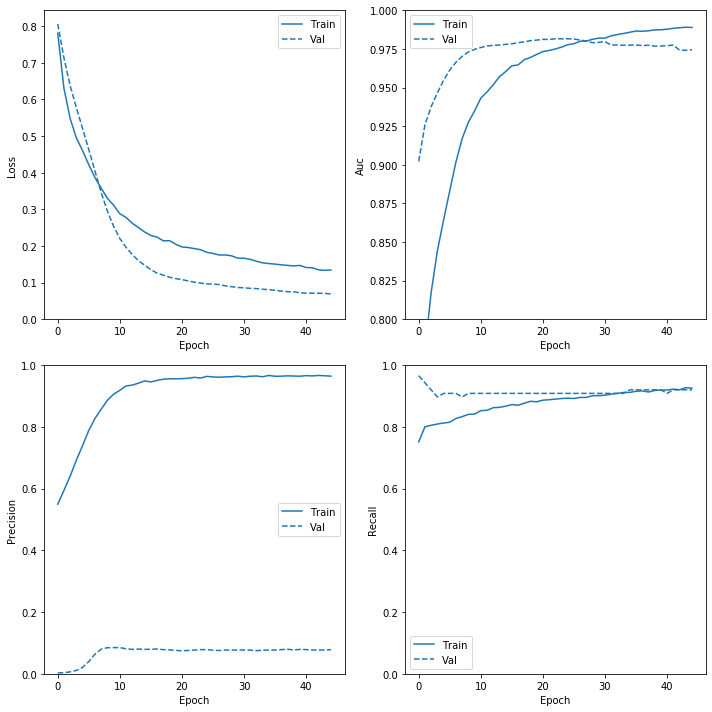

In [55]:
plot_metrics(resampled_history)

In [56]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.09164309422148233
tp :  82.0
fp :  1090.0
tn :  55784.0
fn :  6.0
accuracy :  0.9807591
precision :  0.06996587
recall :  0.9318182
auc :  0.9806923


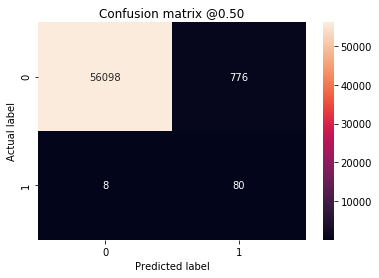

In [58]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
    print(name, ': ', value)

plot_cm(test_labels, test_predictions_weighted)

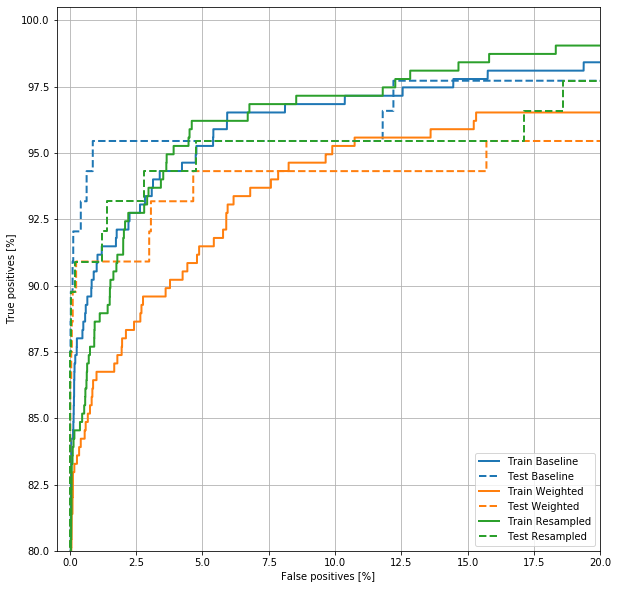

In [62]:
plt.figure(figsize=(10,10))
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')

plt.ylim(80, 100.5)
plt.xlim(-0.5,20)
plt.legend(loc='lower right')